In [2]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import matplotlib.pyplot as plt

class Island:
    def __init__(self, xcentr=5, ycentr=5, radius=1):
        self.xcentr = xcentr
        self.ycentr = ycentr
        self.radius = radius

    def belongs_to_boarder(self, x, y):
        dist = ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5
        if dist <= self.radius:
            return True
        else:
            return False

    def get_dist(self, x, y):
        return ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5 - self.radius

    def draw_island(self, color='blue'):
        return plt.Circle((self.xcentr, self.ycentr), self.radius, color=color)

    def getCoords(self):
        return [self.xcentr, self.ycentr]


In [4]:
x_lower_bound = 0
x_upper_bound = 10
y_lower_bound = 0
y_upper_bound = 10

a = {}

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class Ship:
    def __init__(self, x = 1, y = 5, v = 1, direction = 0):
        self.x = x
        self.y = y
        self.v = v
        self.direction = direction
        self.prev_d = self.direction
        self.positions = [[self.x, self.y]]
        self.cum_d = 0
        
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)
        self.cum_d += abs(self.direction - self.prev_d)
        self.prev_d = self.direction
        
    def getCoords(self):
        return [self.x, self.y]
    
    def add_position(self):
        self.positions.append([self.x, self.y])
        
    def get_positions(self):
        return self.positions

In [180]:
class Environment(object):
    def __init__(self):
        super(Environment, self).__init__()
        self.action_space = ['left', 'right', 'idle']
        self.n_actions = len(self.action_space)
        self.n_features = 2

        self.build_environment()
        
        self.route = []
        self.list_of_route = []
        self.d = {}
        self.f = {}
        
        self.prev_dist = 0
        self.prev_i_dist = 0
        self.n_angles = 0

        self.i = 0

        self.c = True

        self.longest = 0

        self.shortest = 0
        
    def get_state(self):
        a = self.ship.getCoords()
        b = self.island.getCoords()
        c = self.flag.getCoords()
        dxi, dyi = b[0] - a[0], b[1] - a[1]
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        i_angle = math.atan2(dyi, dxi)
        return [f_angle - self.ship.direction, (dxf ** 2 + dyf ** 2) ** 0.5, i_angle - self.ship.direction, (dxi ** 2 + dyi ** 2) ** 0.5]

    def build_environment(self):
        self.n_angles = 0
        rate = random.uniform(0.3, 0.5)
        dist = random.uniform(7, 15)
        angle = random.uniform(0, 2*math.pi)
        self.flag = Island(0, 0, 1)
        self.ship = Ship(dist * math.cos(angle), dist * math.sin(angle))
        self.island = Island(rate * dist * math.cos(angle), rate * dist * math.sin(angle))
        a = self.ship.getCoords()
        c = self.flag.getCoords()
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        self.ship.direction = f_angle
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.island.get_dist(self.ship.x, self.ship.y)
    
    def reset(self):
        self.build_environment()
        self.d = {}
        self.i = 0
        return self.get_state()
    
    def step(self, action):
        dt = 1
        
        state = self.ship.getCoords()

        if action == 0:
            self.ship.direction += math.pi / 6
            self.n_angles += 1
        elif action == 1:
            self.ship.direction -= math.pi / 6
            self.n_angles += 1
        # elif action == 2:
        #     self.ship.v += 0.25
        # elif action == 3:
        #     self.ship.v -= 0.25
        
        self.ship.move(dt)
        
        self.ship.add_position()

        next_state = self.get_state()

        self.i += 1
        
        if self.flag.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = 20000
            done = True
            
            self.d = {}
            self.i = 0
            reward -= self.n_angles * 500

        elif self.island.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = -10000
            done = True

            self.d = {}
            self.i = 0
            reward -= self.n_angles * 500
            
        elif len(self.ship.get_positions()) > 25:
            done = True
            self.d = {}
            self.i = 0
            # print("Time limit exceeded")
            reward = -1000 * (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 2
            reward -= self.n_angles * 500

        else:
            reward = (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 3
            reward -= 0.1 * (self.prev_i_dist - self.island.get_dist(self.ship.x, self.ship.y)) ** 3
            if reward < 0:
                reward *= 10
            # reward += 10 * (1 - self.ship.cum_d ** 2) * math.exp( - 0.5 * self.ship.cum_d ** 2) - 5
            done = False
        
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.island.get_dist(self.ship.x, self.ship.y)

        return next_state, reward, done 
    
    def draw_map(self):
        field, ax = plt.subplots()
        ax.set(xlim=(x_upper_bound * -2, x_upper_bound * 2), ylim=(y_upper_bound * -2, y_upper_bound * 2))
        ax.set_aspect(1)
        ax.add_artist(self.island.draw_island('green'))
        ax.add_artist(self.flag.draw_island())
        pos = self.ship.get_positions()
        for i in range(len(pos) - 1):
            ax.plot([pos[i][0], pos[i + 1][0]], [pos[i][1], pos[i + 1][1]], marker = 'o', color='r')
        plt.show()

    def final(self):
        print('The shortest route:', self.shortest)
        print('The longest route:', self.longest)

def final_states():
    return a

if __name__ == '__main__':
    env = Environment()

Ключевая идея: подаем на вектор относительных координат острова и флага, а также пеленги на них.

In [181]:
BATCH_SIZE = 100
LR = 0.03
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
NUM_ACTIONS = env.n_actions
NUM_STATES = 4
EPISODES = 200000

In [182]:
from torch.autograd import Variable 
class LSTM1(nn.Module):
    def __init__(self, num_classes=NUM_ACTIONS,
                 input_size=NUM_STATES,
                 hidden_size=NUM_STATES-2,
                 num_layers=2):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self, x):
        # h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        # c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [183]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, 160)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(160, 80)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(80, NUM_ACTIONS)
        self.fc4.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [184]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [185]:
class DQN():
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()
        
    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1
        
    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action
    
    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...


  0%|                                                                                       | 0/200000 [00:00<?, ?it/s]

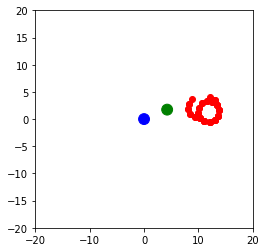

  0%|▎                                                                         | 1000/200000 [00:11<1:03:30, 52.23it/s]

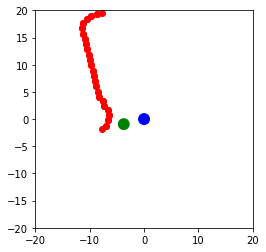

  1%|▋                                                                         | 2000/200000 [00:30<1:00:03, 54.95it/s]

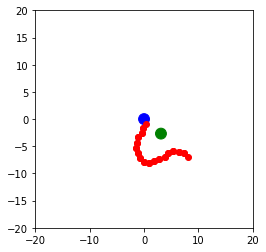

  1%|█▏                                                                          | 2998/200000 [00:46<54:27, 60.30it/s]

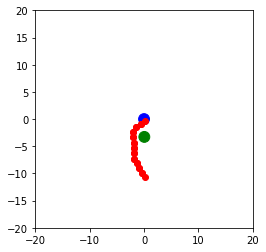

  2%|█▍                                                                        | 3999/200000 [01:16<1:48:22, 30.14it/s]

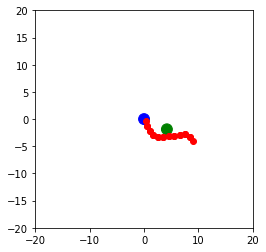

  2%|█▉                                                                          | 4993/200000 [01:31<32:54, 98.78it/s]

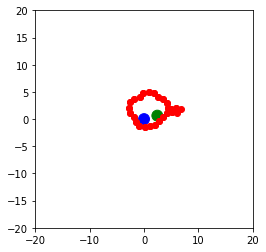

  3%|██▏                                                                        | 5995/200000 [01:41<30:19, 106.61it/s]

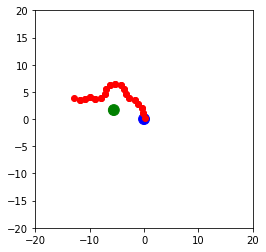

  3%|██▌                                                                        | 6997/200000 [01:52<29:59, 107.26it/s]

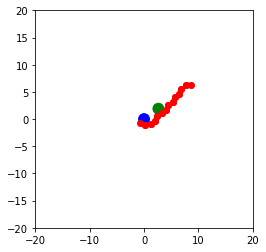

  4%|███                                                                         | 7999/200000 [02:02<34:37, 92.40it/s]

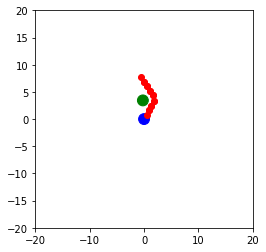

  4%|███▍                                                                        | 8997/200000 [02:13<53:34, 59.42it/s]

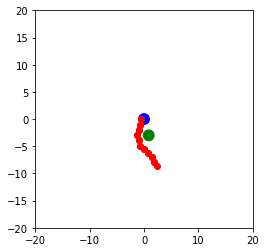

  5%|███▊                                                                        | 9990/200000 [02:24<33:24, 94.77it/s]

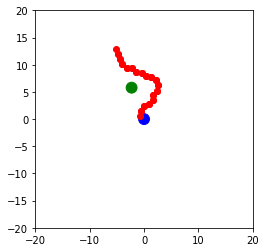

  5%|████                                                                       | 10998/200000 [02:36<33:25, 94.24it/s]

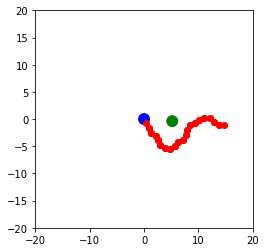

  6%|████▍                                                                      | 11994/200000 [02:46<31:33, 99.30it/s]

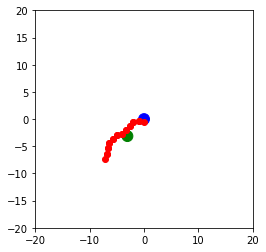

  6%|████▊                                                                      | 12996/200000 [02:57<31:27, 99.06it/s]

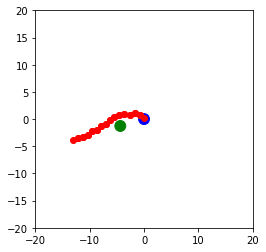

  7%|█████▏                                                                    | 13997/200000 [03:07<29:19, 105.74it/s]

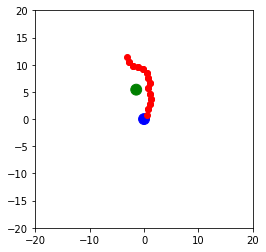

  7%|█████▌                                                                     | 14992/200000 [03:18<31:59, 96.38it/s]

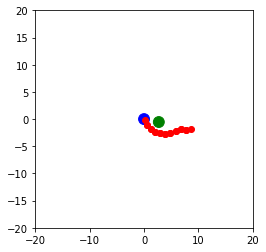

  8%|█████▉                                                                    | 16000/200000 [03:28<28:52, 106.23it/s]

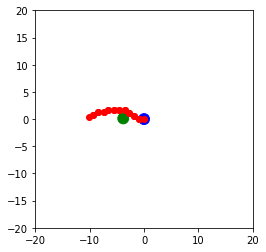

  8%|██████▎                                                                   | 16995/200000 [03:39<30:00, 101.62it/s]

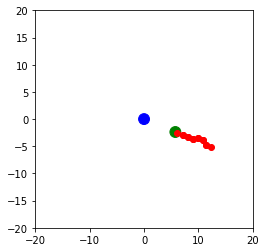

  9%|██████▋                                                                   | 17994/200000 [03:49<30:06, 100.77it/s]

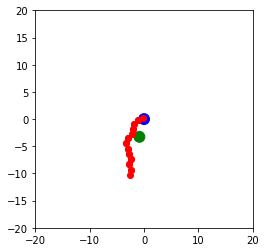

 10%|███████                                                                   | 19000/200000 [03:59<29:06, 103.64it/s]

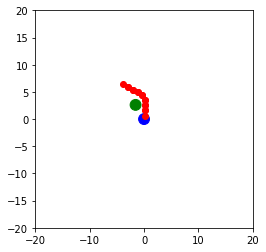

 10%|███████▍                                                                   | 19996/200000 [04:10<30:29, 98.37it/s]

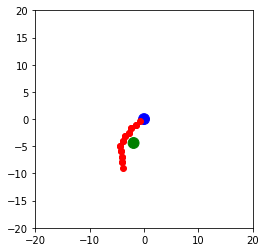

 10%|███████▊                                                                  | 20990/200000 [04:20<29:02, 102.74it/s]

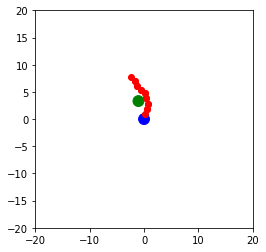

 11%|████████▏                                                                  | 21989/200000 [04:30<30:26, 97.48it/s]

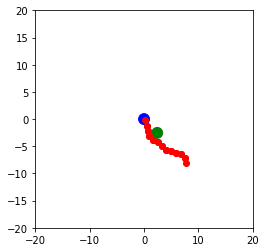

 11%|████████▌                                                                 | 22993/200000 [04:40<27:33, 107.04it/s]

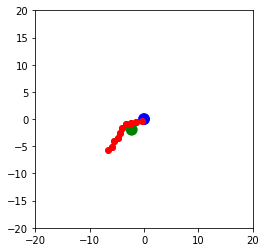

 12%|████████▉                                                                  | 23997/200000 [04:49<29:25, 99.70it/s]

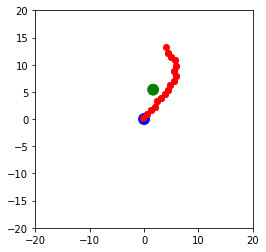

 12%|█████████▎                                                                 | 24994/200000 [05:00<29:46, 97.97it/s]

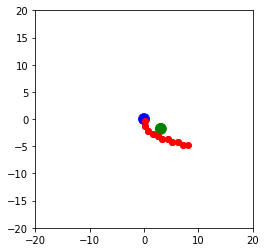

 13%|█████████▋                                                                 | 25993/200000 [05:10<29:50, 97.19it/s]

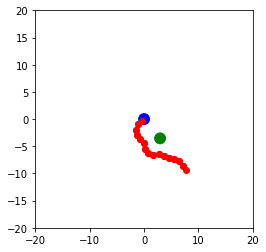

 13%|██████████                                                                 | 26994/200000 [05:21<30:12, 95.45it/s]

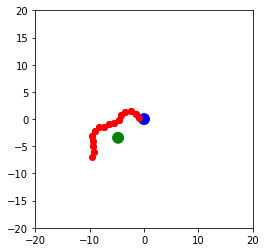

 14%|██████████▍                                                                | 27991/200000 [05:31<29:18, 97.80it/s]

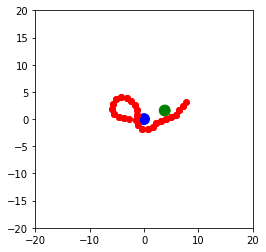

 14%|██████████▊                                                                | 28997/200000 [05:42<29:27, 96.72it/s]

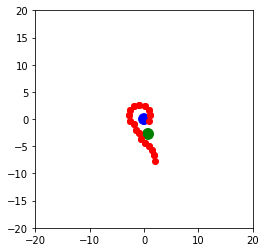

 15%|███████████                                                               | 29998/200000 [05:52<27:38, 102.51it/s]

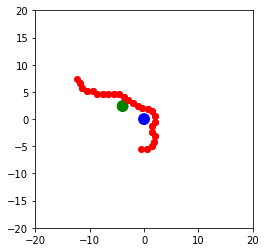

 16%|███████████▋                                                               | 31000/200000 [06:03<30:38, 91.92it/s]

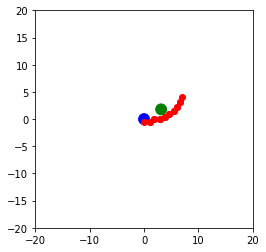

 16%|███████████▉                                                               | 31995/200000 [06:13<28:32, 98.11it/s]

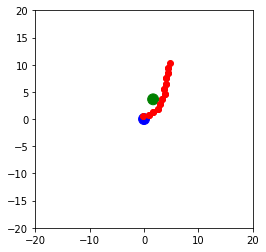

 16%|████████████▏                                                             | 33000/200000 [06:24<26:01, 106.92it/s]

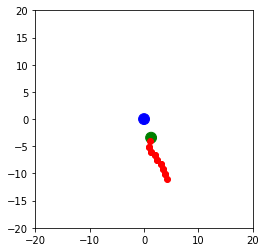

 17%|████████████▌                                                             | 33993/200000 [06:34<27:24, 100.94it/s]

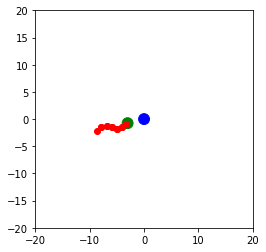

 17%|█████████████                                                              | 34994/200000 [06:44<28:26, 96.71it/s]

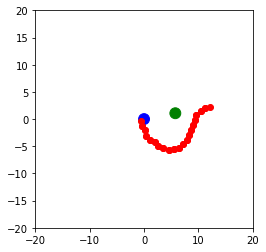

 18%|█████████████▍                                                             | 35992/200000 [06:55<30:05, 90.83it/s]

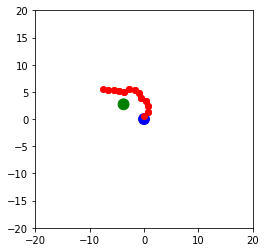

 18%|█████████████▋                                                            | 36994/200000 [07:05<26:57, 100.77it/s]

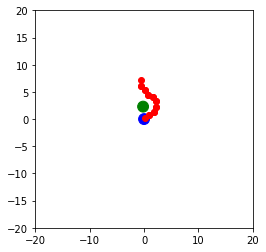

 19%|██████████████                                                            | 37999/200000 [07:15<25:32, 105.68it/s]

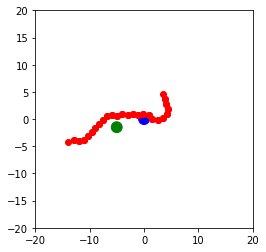

 20%|██████████████▋                                                            | 39000/200000 [07:25<27:58, 95.90it/s]

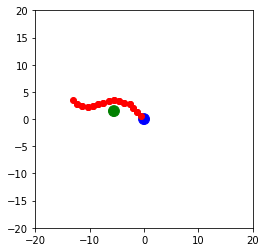

 20%|██████████████▉                                                            | 39997/200000 [07:35<27:26, 97.19it/s]

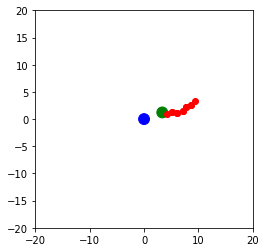

 20%|███████████████▏                                                          | 40995/200000 [07:45<24:39, 107.50it/s]

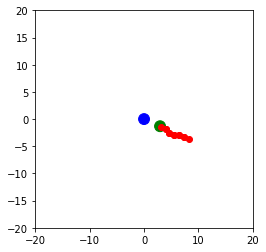

 21%|███████████████▌                                                          | 41996/200000 [07:55<25:03, 105.12it/s]

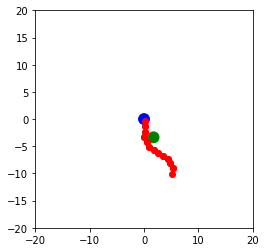

 21%|███████████████▉                                                          | 42992/200000 [08:06<25:41, 101.83it/s]

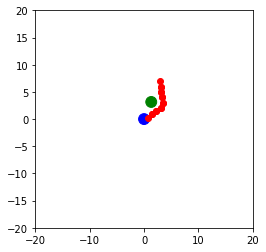

 22%|████████████████▍                                                          | 43993/200000 [08:16<26:21, 98.63it/s]

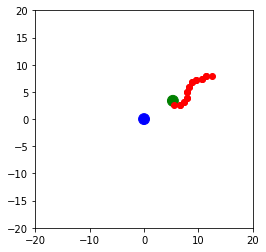

 22%|████████████████▋                                                         | 44996/200000 [08:26<25:46, 100.23it/s]

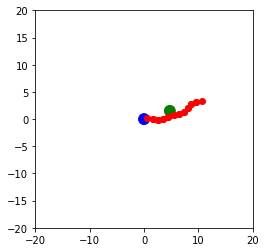

 23%|█████████████████▏                                                         | 45991/200000 [08:36<27:18, 93.99it/s]

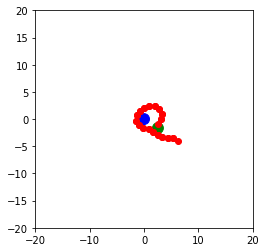

 23%|█████████████████▌                                                         | 46998/200000 [08:47<26:12, 97.33it/s]

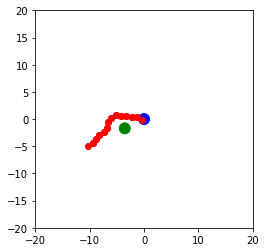

 24%|█████████████████▊                                                        | 47991/200000 [08:57<24:41, 102.59it/s]

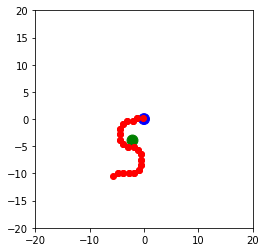

 24%|██████████████████▎                                                        | 48996/200000 [09:07<26:41, 94.27it/s]

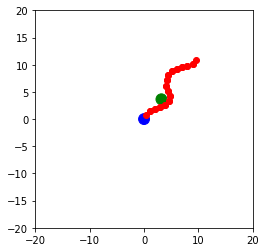

 25%|██████████████████▍                                                       | 49997/200000 [09:17<24:02, 103.97it/s]

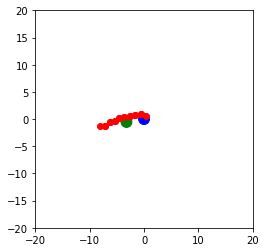

 25%|██████████████████▊                                                       | 50999/200000 [09:27<23:36, 105.15it/s]

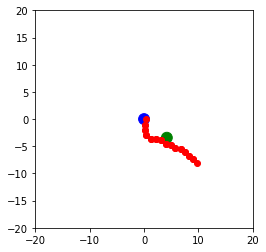

 26%|███████████████████▍                                                       | 51996/200000 [09:37<25:15, 97.63it/s]

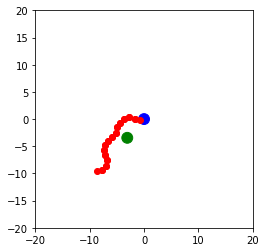

 26%|███████████████████▊                                                       | 52996/200000 [09:47<25:56, 94.48it/s]

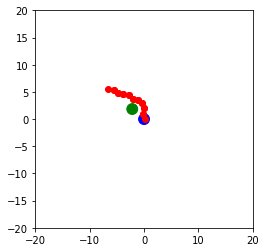

 27%|████████████████████▎                                                      | 54000/200000 [09:57<25:11, 96.60it/s]

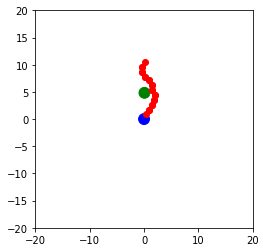

 27%|████████████████████▎                                                     | 54996/200000 [10:07<22:47, 106.02it/s]

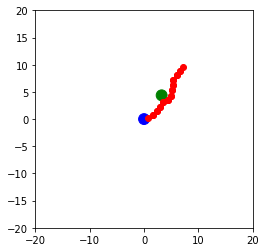

 28%|████████████████████▉                                                      | 55998/200000 [10:17<27:31, 87.21it/s]

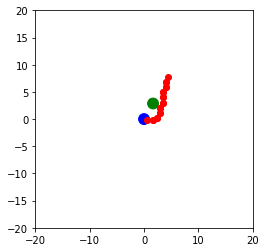

 28%|█████████████████████▎                                                     | 56992/200000 [10:28<28:57, 82.29it/s]

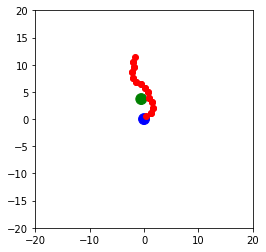

 29%|█████████████████████▋                                                     | 57992/200000 [10:38<24:46, 95.53it/s]

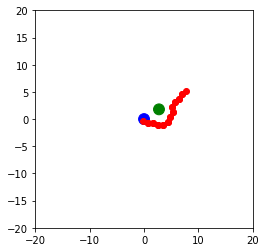

 29%|██████████████████████                                                     | 58989/200000 [10:48<24:54, 94.33it/s]

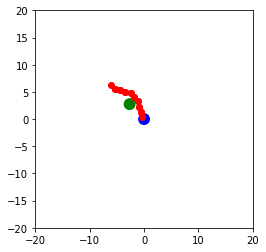

 30%|██████████████████████▍                                                    | 59996/200000 [10:58<25:27, 91.67it/s]

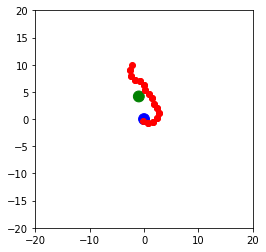

 30%|██████████████████████▌                                                   | 60996/200000 [11:09<22:08, 104.61it/s]

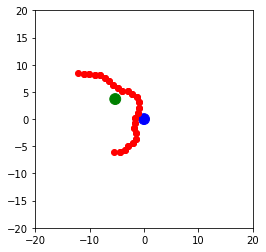

 31%|██████████████████████▉                                                   | 61990/200000 [11:19<22:22, 102.81it/s]

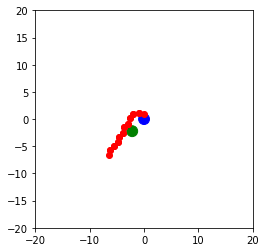

 31%|███████████████████████▌                                                   | 62994/200000 [11:29<24:24, 93.54it/s]

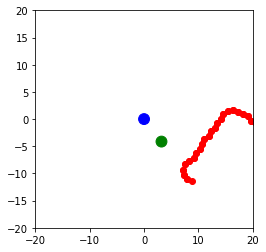

 32%|███████████████████████▉                                                   | 63993/200000 [11:40<23:05, 98.19it/s]

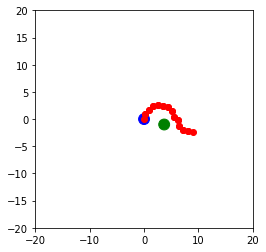

 32%|████████████████████████                                                  | 64999/200000 [11:50<22:05, 101.81it/s]

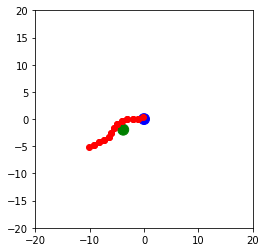

 33%|████████████████████████▋                                                  | 65992/200000 [12:00<22:31, 99.18it/s]

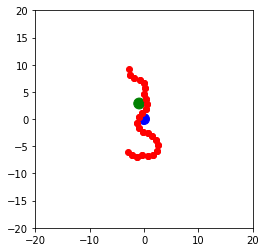

 33%|█████████████████████████                                                  | 66999/200000 [12:11<23:13, 95.42it/s]

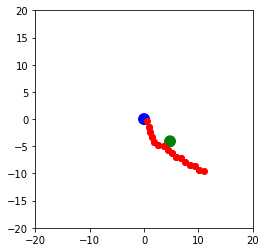

 34%|█████████████████████████▍                                                 | 67997/200000 [12:21<23:22, 94.13it/s]

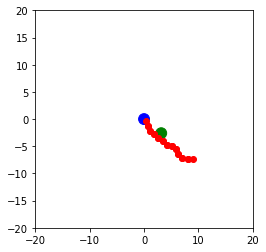

 34%|█████████████████████████▊                                                 | 68992/200000 [12:31<21:50, 99.94it/s]

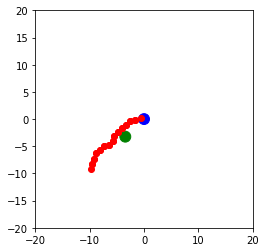

 35%|█████████████████████████▉                                                | 70000/200000 [12:42<21:18, 101.64it/s]

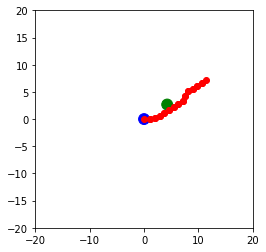

 35%|██████████████████████████▌                                                | 70994/200000 [12:52<21:54, 98.18it/s]

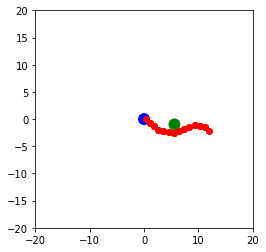

 36%|██████████████████████████▉                                                | 71991/200000 [13:02<23:31, 90.68it/s]

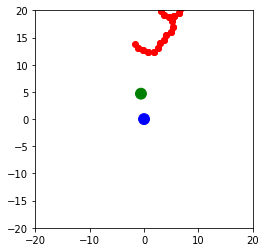

 36%|███████████████████████████▎                                               | 72998/200000 [13:12<22:06, 95.77it/s]

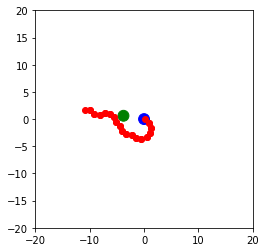

 37%|███████████████████████████▋                                               | 73998/200000 [13:22<21:11, 99.11it/s]

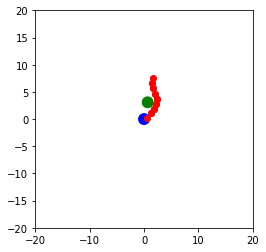

 37%|███████████████████████████▋                                              | 74993/200000 [13:32<20:34, 101.29it/s]

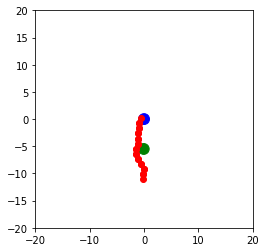

 38%|████████████████████████████                                              | 75995/200000 [13:42<20:16, 101.97it/s]

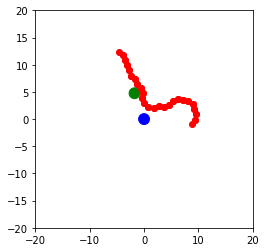

 38%|████████████████████████████▍                                             | 76993/200000 [13:52<20:08, 101.80it/s]

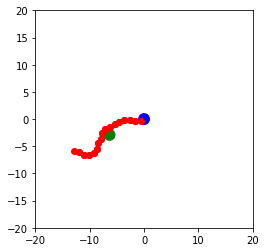

 39%|█████████████████████████████▏                                             | 77993/200000 [14:02<21:13, 95.80it/s]

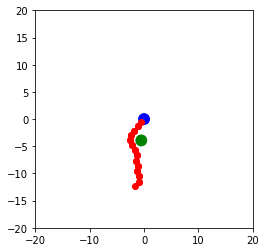

 39%|█████████████████████████████▌                                             | 78996/200000 [14:13<21:50, 92.32it/s]

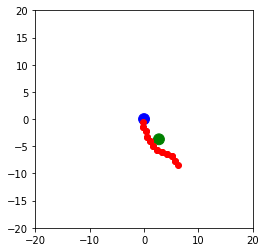

 40%|█████████████████████████████▌                                            | 79996/200000 [14:23<19:49, 100.90it/s]

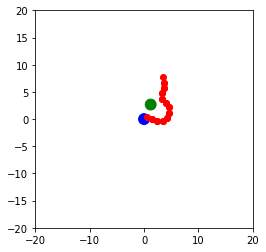

 40%|██████████████████████████████▍                                            | 81000/200000 [14:33<21:31, 92.13it/s]

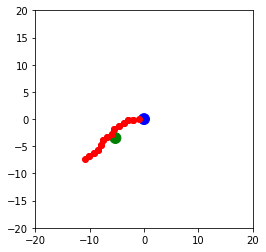

 41%|██████████████████████████████▎                                           | 81993/200000 [14:43<18:50, 104.41it/s]

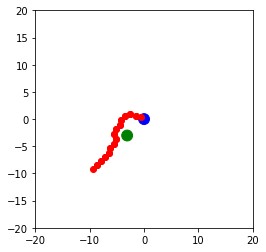

 42%|███████████████████████████████▏                                           | 83000/200000 [14:53<19:57, 97.67it/s]

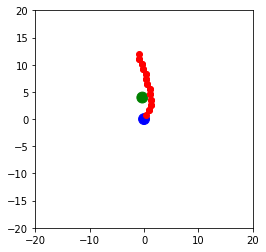

 42%|███████████████████████████████                                           | 83997/200000 [15:03<18:10, 106.36it/s]

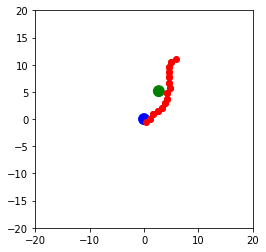

 42%|███████████████████████████████▊                                           | 84996/200000 [15:13<20:34, 93.18it/s]

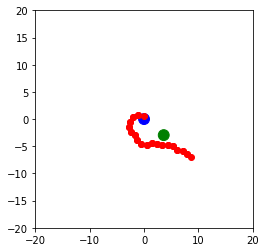

 43%|████████████████████████████████▏                                          | 85997/200000 [15:23<19:53, 95.56it/s]

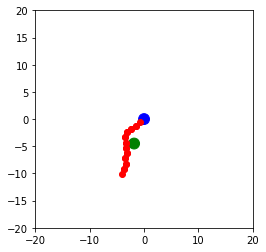

 43%|████████████████████████████████▌                                          | 86997/200000 [15:34<18:53, 99.66it/s]

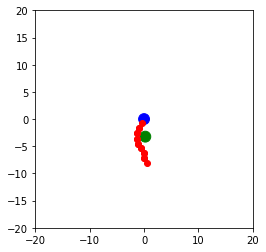

 44%|████████████████████████████████▌                                         | 87989/200000 [15:44<18:36, 100.31it/s]

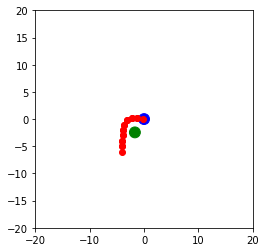

 44%|████████████████████████████████▉                                         | 88990/200000 [15:54<17:58, 102.94it/s]

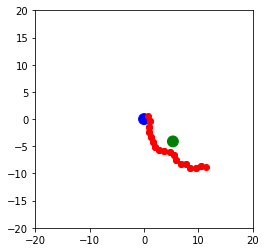

 45%|█████████████████████████████████▋                                         | 89989/200000 [16:04<19:57, 91.89it/s]

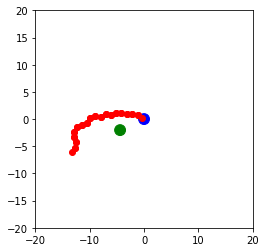

 45%|██████████████████████████████████                                         | 90998/200000 [16:15<18:54, 96.11it/s]

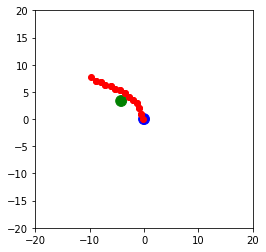

 46%|██████████████████████████████████▍                                        | 91993/200000 [16:25<18:19, 98.19it/s]

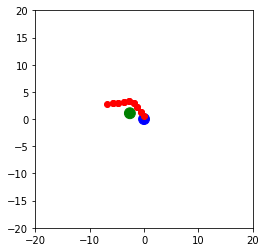

 46%|██████████████████████████████████▍                                       | 92997/200000 [16:35<17:24, 102.48it/s]

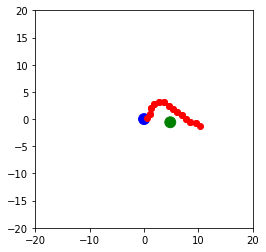

 47%|██████████████████████████████████▊                                       | 93995/200000 [16:45<17:26, 101.27it/s]

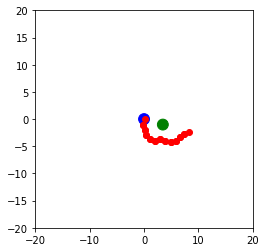

 48%|███████████████████████████████████▏                                      | 95000/200000 [16:55<16:40, 104.91it/s]

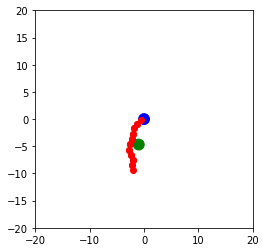

 48%|███████████████████████████████████▉                                       | 95989/200000 [17:06<17:20, 99.93it/s]

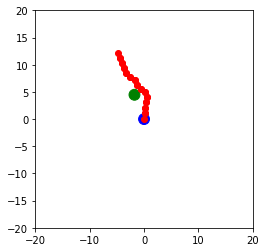

 48%|████████████████████████████████████▎                                      | 96995/200000 [17:16<19:08, 89.70it/s]

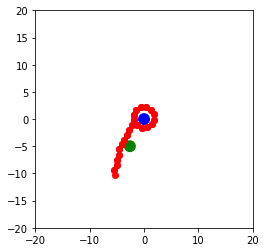

 49%|████████████████████████████████████▋                                      | 97998/200000 [17:26<17:54, 94.90it/s]

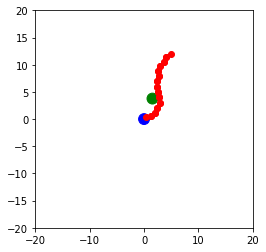

 49%|█████████████████████████████████████                                      | 98993/200000 [17:36<17:14, 97.64it/s]

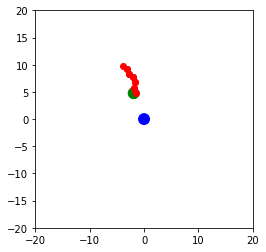

 50%|████████████████████████████████████▉                                     | 99997/200000 [17:46<15:58, 104.33it/s]

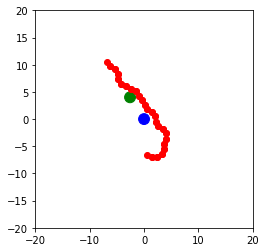

 50%|█████████████████████████████████████▎                                    | 100999/200000 [17:56<17:20, 95.19it/s]

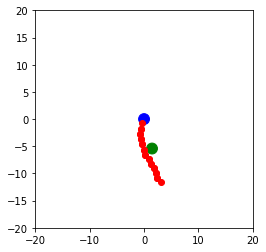

 51%|█████████████████████████████████████▋                                    | 101993/200000 [18:07<16:34, 98.52it/s]

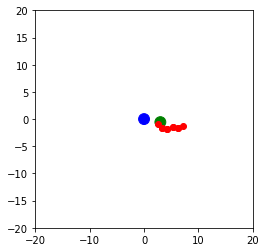

 51%|██████████████████████████████████████                                    | 102999/200000 [18:17<16:28, 98.10it/s]

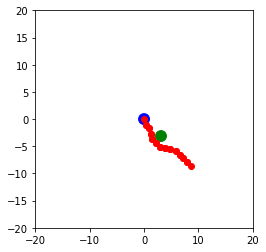

 52%|██████████████████████████████████████▍                                   | 103996/200000 [18:27<16:10, 98.96it/s]

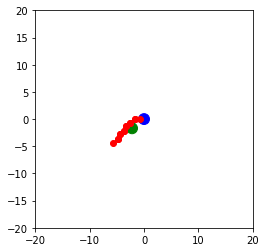

 52%|██████████████████████████████████████▎                                  | 104994/200000 [18:37<15:43, 100.73it/s]

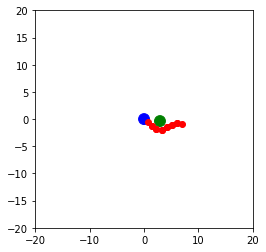

 53%|██████████████████████████████████████▋                                  | 105998/200000 [18:47<14:42, 106.49it/s]

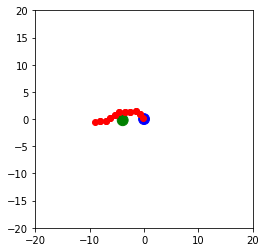

 54%|███████████████████████████████████████▌                                  | 107000/200000 [18:57<16:49, 92.17it/s]

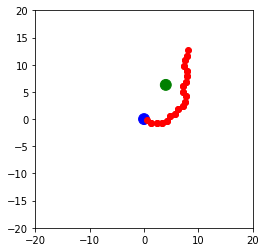

 54%|███████████████████████████████████████▍                                 | 108000/200000 [19:07<14:59, 102.27it/s]

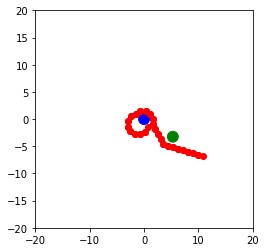

 54%|████████████████████████████████████████▎                                 | 108995/200000 [19:17<15:27, 98.17it/s]

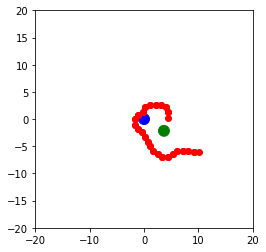

 55%|████████████████████████████████████████▏                                | 109990/200000 [19:28<14:11, 105.71it/s]

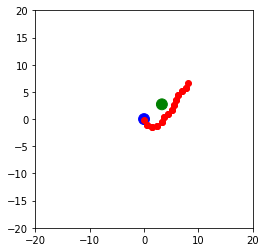

 55%|█████████████████████████████████████████                                 | 110999/200000 [19:38<15:45, 94.11it/s]

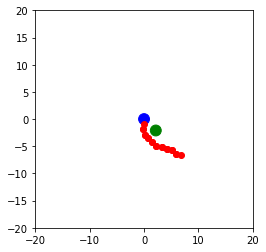

 56%|████████████████████████████████████████▉                                | 111993/200000 [19:48<14:25, 101.67it/s]

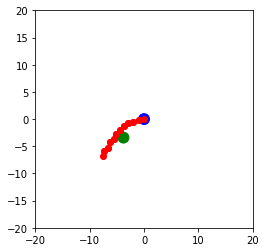

 56%|█████████████████████████████████████████▊                                | 112995/200000 [19:58<15:15, 95.08it/s]

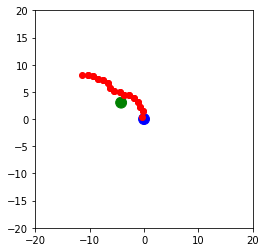

 57%|█████████████████████████████████████████▌                               | 113994/200000 [20:08<13:42, 104.56it/s]

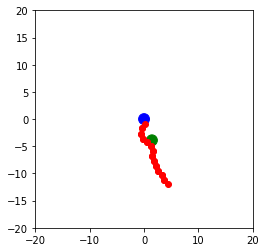

 57%|██████████████████████████████████████████▌                               | 114999/200000 [20:18<14:35, 97.12it/s]

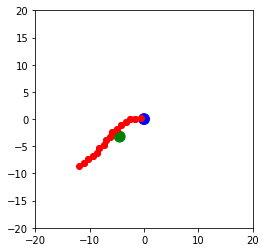

 58%|██████████████████████████████████████████▎                              | 115994/200000 [20:28<13:44, 101.89it/s]

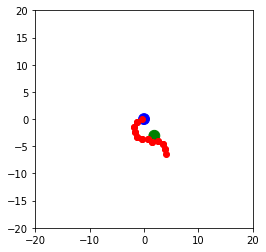

 58%|██████████████████████████████████████████▋                              | 116994/200000 [20:38<13:04, 105.78it/s]

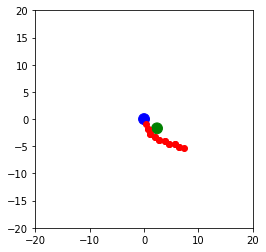

 59%|███████████████████████████████████████████                              | 117999/200000 [20:48<13:23, 102.11it/s]

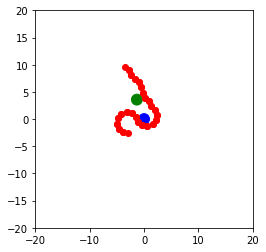

 59%|████████████████████████████████████████████                              | 118997/200000 [20:58<13:34, 99.46it/s]

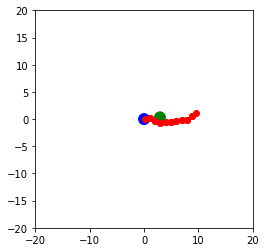

 60%|███████████████████████████████████████████▊                             | 119997/200000 [21:08<12:27, 106.96it/s]

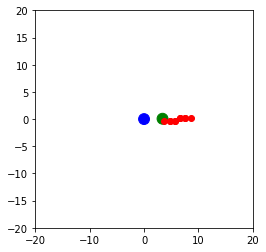

 60%|████████████████████████████████████████████▊                             | 120996/200000 [21:18<14:22, 91.56it/s]

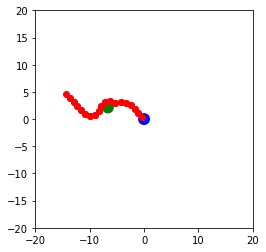

 61%|████████████████████████████████████████████▌                            | 121992/200000 [21:28<12:45, 101.88it/s]

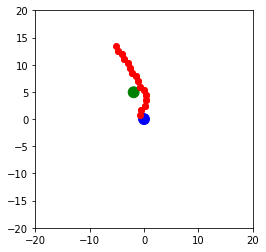

 61%|█████████████████████████████████████████████▌                            | 122992/200000 [21:38<13:43, 93.51it/s]

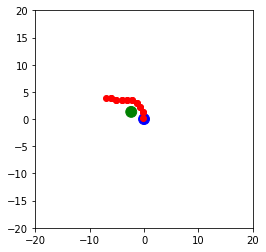

 62%|█████████████████████████████████████████████▎                           | 123993/200000 [21:48<12:35, 100.58it/s]

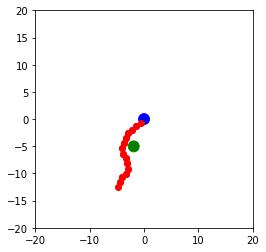

 62%|██████████████████████████████████████████████▏                           | 124997/200000 [21:58<12:52, 97.07it/s]

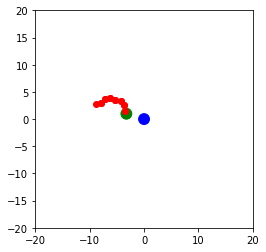

 63%|██████████████████████████████████████████████▌                           | 126000/200000 [22:08<12:43, 96.91it/s]

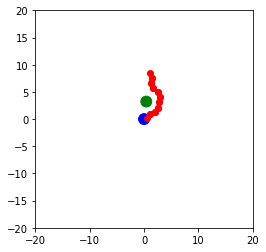

 63%|██████████████████████████████████████████████▎                          | 126995/200000 [22:18<12:09, 100.03it/s]

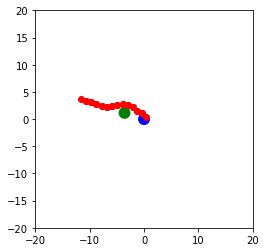

 64%|███████████████████████████████████████████████▎                          | 127996/200000 [22:28<12:36, 95.13it/s]

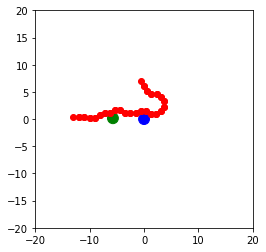

 64%|███████████████████████████████████████████████▋                          | 128991/200000 [22:39<11:55, 99.19it/s]

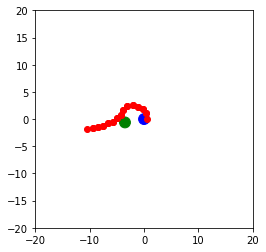

 65%|███████████████████████████████████████████████▍                         | 129990/200000 [22:49<11:21, 102.75it/s]

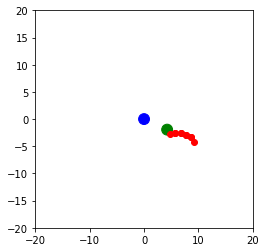

 65%|████████████████████████████████████████████████▍                         | 130994/200000 [22:59<11:47, 97.48it/s]

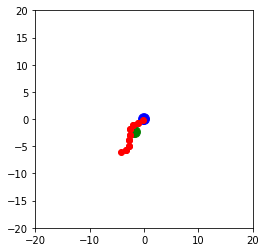

 66%|████████████████████████████████████████████████▊                         | 131994/200000 [23:09<12:19, 91.92it/s]

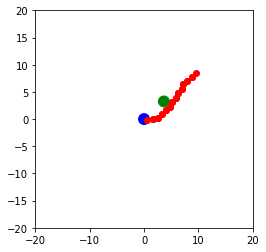

 66%|█████████████████████████████████████████████████▏                        | 132994/200000 [23:19<11:28, 97.32it/s]

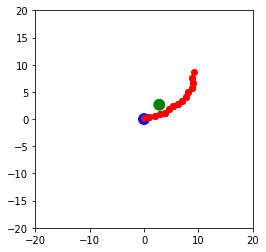

 67%|█████████████████████████████████████████████████▌                        | 133992/200000 [23:30<11:11, 98.33it/s]

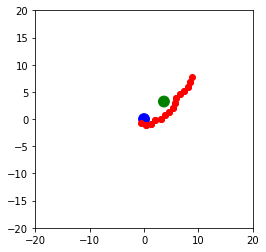

 67%|█████████████████████████████████████████████████▉                        | 134998/200000 [23:40<11:22, 95.19it/s]

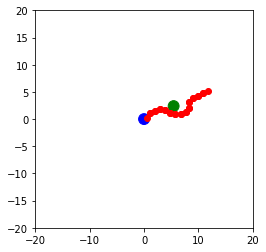

 68%|█████████████████████████████████████████████████▋                       | 135990/200000 [23:49<10:18, 103.42it/s]

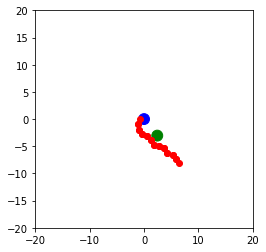

 68%|██████████████████████████████████████████████████▋                       | 136997/200000 [23:59<11:15, 93.29it/s]

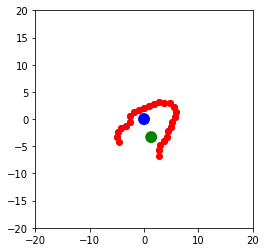

 69%|██████████████████████████████████████████████████▎                      | 137993/200000 [24:10<10:18, 100.18it/s]

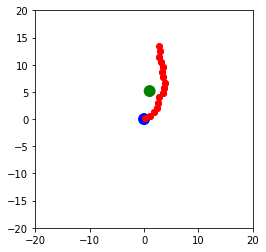

 69%|███████████████████████████████████████████████████▍                      | 138996/200000 [24:20<10:26, 97.35it/s]

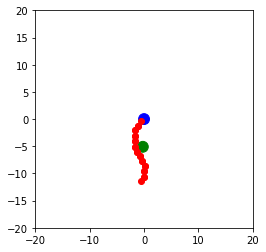

 70%|███████████████████████████████████████████████████                      | 139994/200000 [24:30<09:31, 104.96it/s]

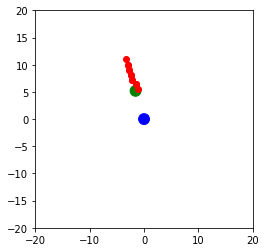

 70%|███████████████████████████████████████████████████▍                     | 140990/200000 [24:40<09:08, 107.54it/s]

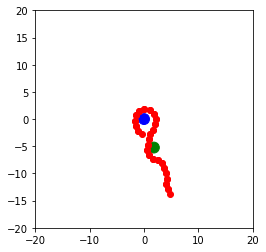

 71%|███████████████████████████████████████████████████▊                     | 141996/200000 [24:50<09:04, 106.61it/s]

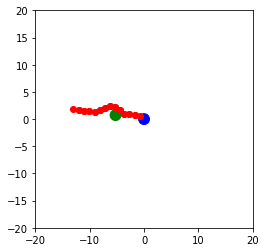

 71%|████████████████████████████████████████████████████▉                     | 142993/200000 [25:00<09:53, 96.13it/s]

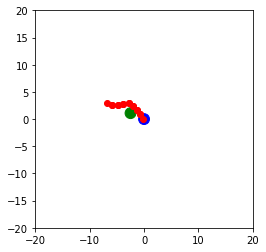

 72%|█████████████████████████████████████████████████████▎                    | 144000/200000 [25:10<09:25, 99.08it/s]

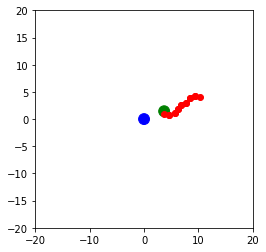

 72%|█████████████████████████████████████████████████████▋                    | 144995/200000 [25:21<09:30, 96.40it/s]

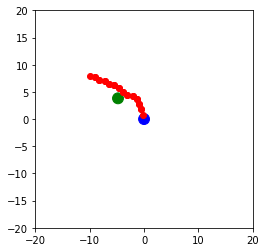

 73%|█████████████████████████████████████████████████████▎                   | 145990/200000 [25:31<08:49, 102.02it/s]

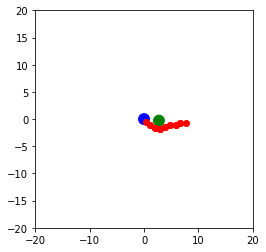

 73%|██████████████████████████████████████████████████████▍                   | 146997/200000 [25:41<09:19, 94.72it/s]

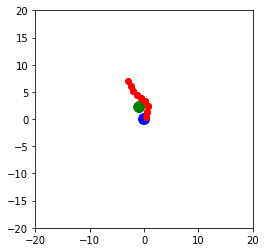

 74%|██████████████████████████████████████████████████████▊                   | 147993/200000 [25:52<08:50, 97.95it/s]

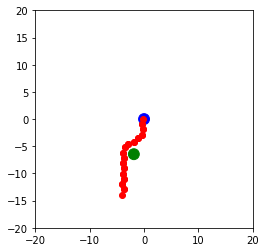

 74%|███████████████████████████████████████████████████████▏                  | 149000/200000 [26:02<08:52, 95.83it/s]

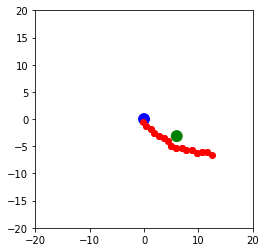

 75%|██████████████████████████████████████████████████████▋                  | 149993/200000 [26:12<08:01, 103.76it/s]

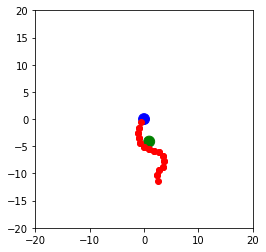

 75%|███████████████████████████████████████████████████████                  | 150990/200000 [26:22<07:42, 105.98it/s]

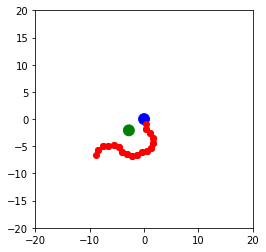

 76%|███████████████████████████████████████████████████████▍                 | 151994/200000 [26:33<07:55, 100.88it/s]

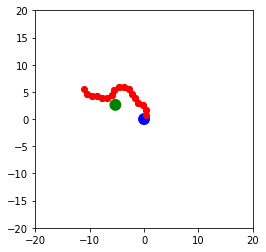

 76%|███████████████████████████████████████████████████████▊                 | 152995/200000 [26:43<07:22, 106.28it/s]

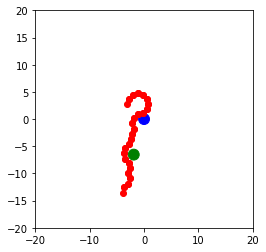

 77%|████████████████████████████████████████████████████████▉                 | 153996/200000 [26:54<08:05, 94.83it/s]

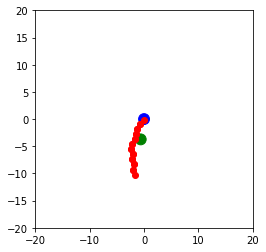

 77%|████████████████████████████████████████████████████████▌                | 154997/200000 [27:04<07:28, 100.43it/s]

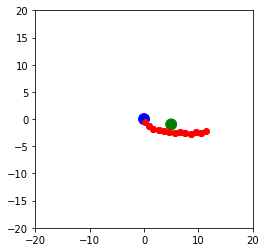

 78%|█████████████████████████████████████████████████████████▋                | 155992/200000 [27:14<07:39, 95.84it/s]

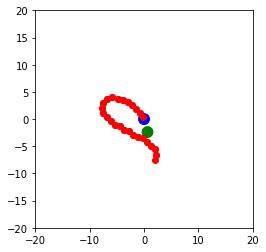

 78%|██████████████████████████████████████████████████████████                | 156999/200000 [27:25<07:17, 98.28it/s]

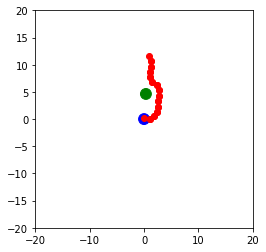

 79%|██████████████████████████████████████████████████████████▍               | 157997/200000 [27:36<07:58, 87.73it/s]

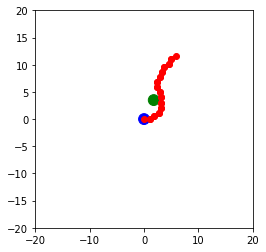

 79%|██████████████████████████████████████████████████████████▊               | 158994/200000 [27:47<07:07, 95.92it/s]

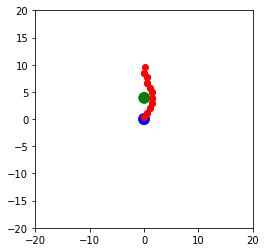

 80%|██████████████████████████████████████████████████████████▍              | 160000/200000 [27:57<05:56, 112.21it/s]

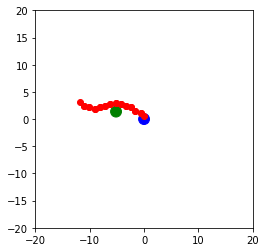

 80%|███████████████████████████████████████████████████████████▌              | 160998/200000 [28:08<07:01, 92.62it/s]

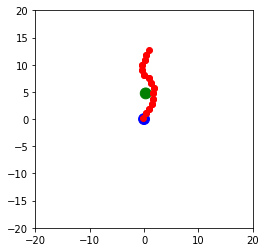

 81%|███████████████████████████████████████████████████████████▏             | 161998/200000 [28:18<06:07, 103.31it/s]

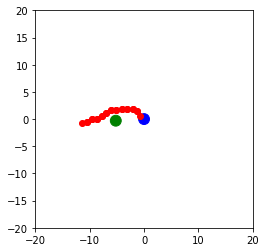

 81%|███████████████████████████████████████████████████████████▍             | 162998/200000 [28:28<05:46, 106.71it/s]

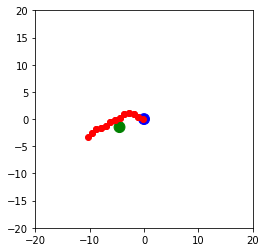

 82%|████████████████████████████████████████████████████████████▋             | 163995/200000 [28:38<06:08, 97.60it/s]

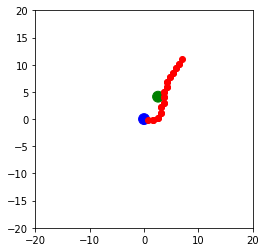

 82%|█████████████████████████████████████████████████████████████             | 164989/200000 [28:48<06:23, 91.18it/s]

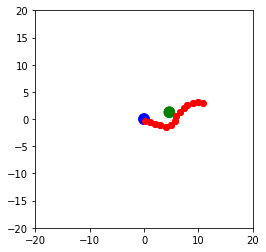

 83%|████████████████████████████████████████████████████████████▌            | 165990/200000 [28:58<05:35, 101.49it/s]

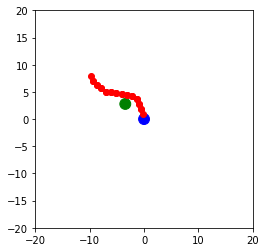

 83%|████████████████████████████████████████████████████████████▉            | 166995/200000 [29:08<05:20, 102.96it/s]

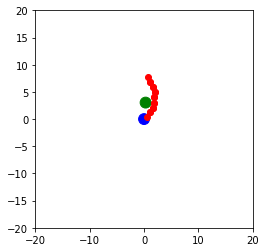

 84%|██████████████████████████████████████████████████████████████▏           | 167996/200000 [29:19<05:22, 99.37it/s]

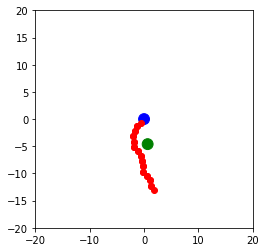

 84%|██████████████████████████████████████████████████████████████▌           | 168995/200000 [29:29<05:36, 92.19it/s]

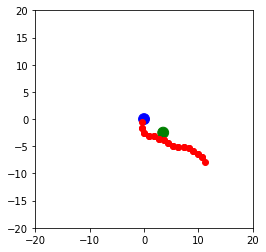

 85%|██████████████████████████████████████████████████████████████           | 169996/200000 [29:38<04:25, 112.82it/s]

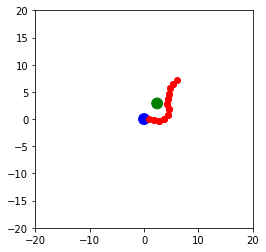

 85%|███████████████████████████████████████████████████████████████▎          | 170993/200000 [29:49<04:53, 98.97it/s]

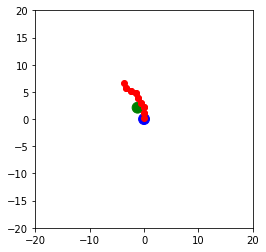

 86%|███████████████████████████████████████████████████████████████▋          | 171994/200000 [29:59<04:50, 96.44it/s]

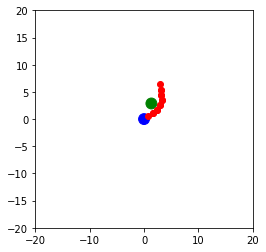

 86%|████████████████████████████████████████████████████████████████          | 172998/200000 [30:09<04:42, 95.55it/s]

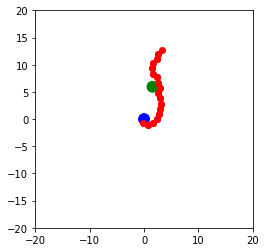

 87%|███████████████████████████████████████████████████████████████▌         | 173994/200000 [30:20<04:02, 107.41it/s]

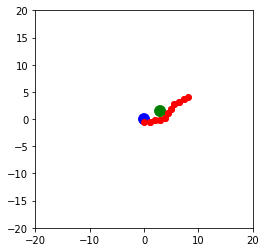

 87%|████████████████████████████████████████████████████████████████▋         | 174992/200000 [30:30<04:32, 91.90it/s]

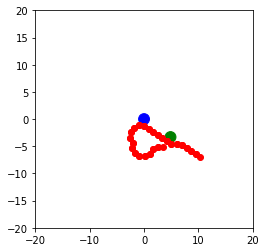

 88%|████████████████████████████████████████████████████████████████▏        | 175990/200000 [30:40<03:56, 101.39it/s]

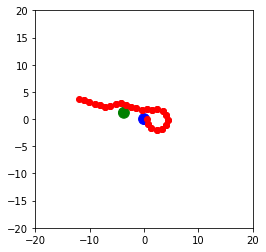

 88%|█████████████████████████████████████████████████████████████████▍        | 176990/200000 [30:50<04:06, 93.48it/s]

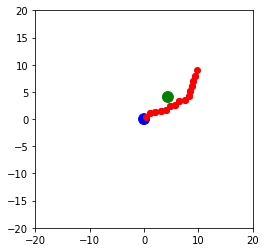

 89%|████████████████████████████████████████████████████████████████▉        | 177999/200000 [31:00<03:28, 105.33it/s]

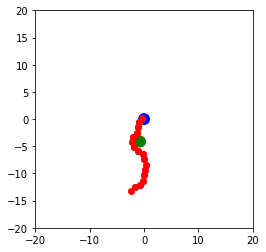

 89%|██████████████████████████████████████████████████████████████████▏       | 178994/200000 [31:10<03:46, 92.69it/s]

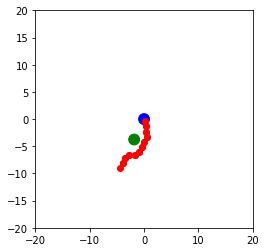

 90%|██████████████████████████████████████████████████████████████████▌       | 179995/200000 [31:21<03:27, 96.18it/s]

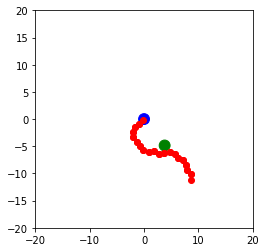

 90%|██████████████████████████████████████████████████████████████████▉       | 180992/200000 [31:31<03:20, 94.73it/s]

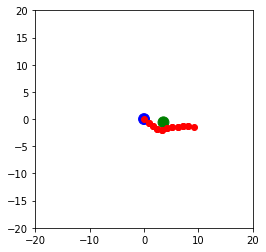

 91%|███████████████████████████████████████████████████████████████████▎      | 181993/200000 [31:41<03:06, 96.35it/s]

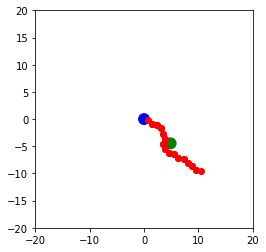

 91%|███████████████████████████████████████████████████████████████████▋      | 182992/200000 [31:51<03:04, 92.10it/s]

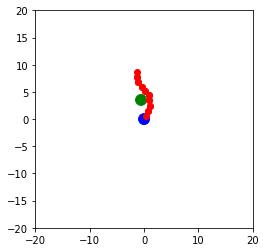

 92%|███████████████████████████████████████████████████████████████████▏     | 183992/200000 [32:01<02:36, 102.26it/s]

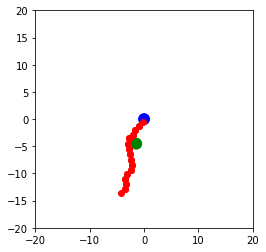

 92%|████████████████████████████████████████████████████████████████████▍     | 184995/200000 [32:11<02:40, 93.29it/s]

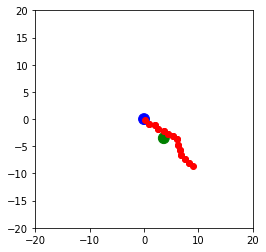

 93%|████████████████████████████████████████████████████████████████████▊     | 185990/200000 [32:22<02:26, 95.38it/s]

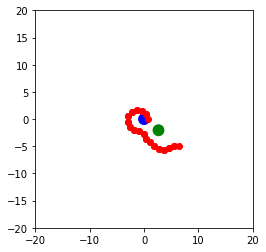

 93%|████████████████████████████████████████████████████████████████████▎    | 186990/200000 [32:32<02:06, 102.61it/s]

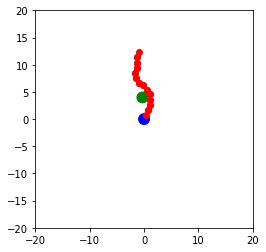

 94%|████████████████████████████████████████████████████████████████████▌    | 187997/200000 [32:42<01:55, 104.15it/s]

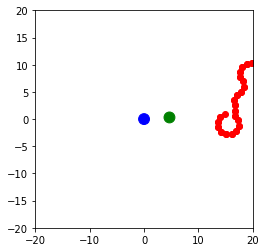

 94%|█████████████████████████████████████████████████████████████████████▉    | 188994/200000 [32:52<01:52, 97.46it/s]

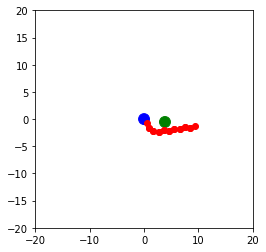

 95%|██████████████████████████████████████████████████████████████████████▎   | 189998/200000 [33:02<01:44, 95.44it/s]

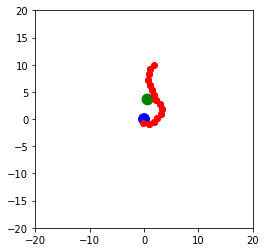

 95%|██████████████████████████████████████████████████████████████████████▋   | 190992/200000 [33:13<01:36, 93.76it/s]

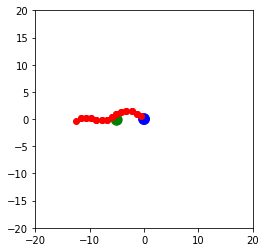

 96%|███████████████████████████████████████████████████████████████████████   | 191995/200000 [33:23<01:22, 97.43it/s]

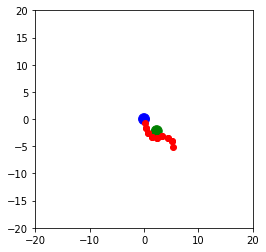

 96%|███████████████████████████████████████████████████████████████████████▍  | 192995/200000 [33:34<01:15, 92.83it/s]

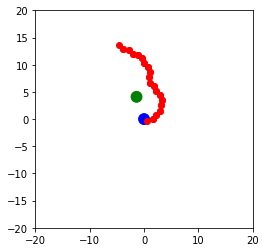

 97%|███████████████████████████████████████████████████████████████████████▊  | 193993/200000 [33:45<01:12, 83.18it/s]

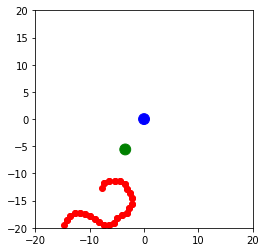

 97%|████████████████████████████████████████████████████████████████████████▏ | 194999/200000 [33:56<00:56, 88.39it/s]

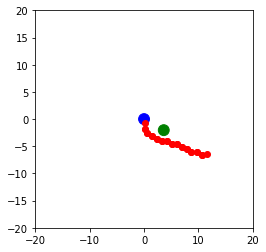

 98%|████████████████████████████████████████████████████████████████████████▌ | 195993/200000 [34:07<00:49, 81.61it/s]

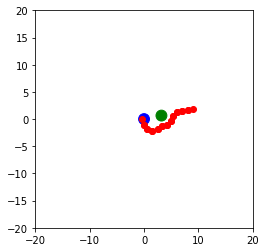

 98%|████████████████████████████████████████████████████████████████████████▉ | 196995/200000 [34:18<00:32, 91.32it/s]

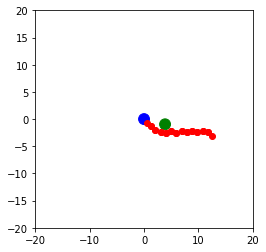

 99%|████████████████████████████████████████████████████████████████████████▎| 197999/200000 [34:28<00:19, 101.10it/s]

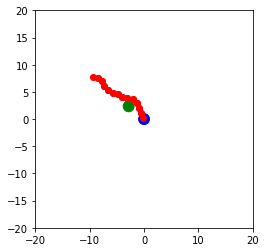

 99%|█████████████████████████████████████████████████████████████████████████▋| 198999/200000 [34:38<00:10, 94.31it/s]

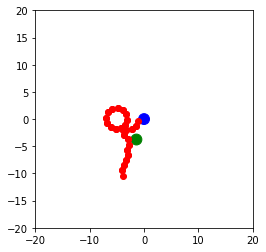

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [34:48<00:00, 95.77it/s]


In [186]:
rewards = []
net = DQN()

def main():
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in tqdm.tqdm(range(EPISODES)):
        state = env.reset()
        step_counter = 0
        sum_rew = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            # reward = reward * 100 if reward > 0 else reward * 5
            sum_rew += reward
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
            if done:
                step_counter_list.append(step_counter)
                # print("episode {}, the reward is {}".format(episode, round(reward, 3)))
                rewards.append(sum_rew)
                if episode % 1000 == 0:
                    env.draw_map()
                # net.plot(net.ax, step_counter_list)
                break

            state = next_state
            

if __name__ == '__main__':
    main()

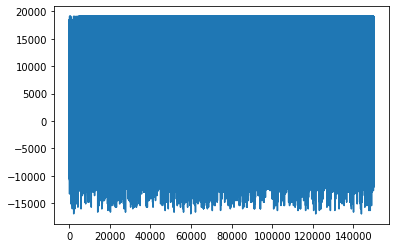

In [176]:
plt.plot(rewards)

In [177]:
m = 0
p = 0
for i in rewards:
    if i < 0:
        m += 1
    else:
        p += 1

In [178]:
m / (m + p)

0.15219333333333335

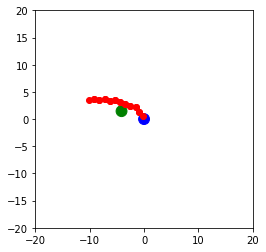

In [179]:
env.draw_map()

In [ ]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions
        print(self.actions)
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        
        if np.random.uniform() < self.epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, state, action, reward, next_state):
        self.check_state_exist(next_state)

        q_predict = self.q_table.loc[state, action]

        if next_state != 'goal' or next_state != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()
        else:
            q_target = reward
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )